In [1]:
import json
import random
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

### Classes

In [2]:
class Category:
    BOOKS = "BOOKS"
    CLOTHING = "CLOTHING"
    ELECTRONICS = "ELECTRONICS"
    GROCERY = "GROCERY"
    PATIO = "PATIO"


class Review:
    def __init__(self, category, text, score):
        self.category = category
        self.text = text
        self.score = score


class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews

    def get_text(self):
        return [x.text for x in self.reviews]

    def get_x(self, vectorizer):
        return vectorizer.transform(self.get_text())

    def get_category(self):
        return [x.category for x in self.reviews]

### Load data

In [3]:
file_names = ['./data/category/Books.json', './data/category/Clothing.json',
              './data/category/Electronics.json', './data/category/Grocery.json', './data/category/Patio.json']
file_categories = [Category.BOOKS, Category.CLOTHING,
                   Category.ELECTRONICS, Category.GROCERY, Category.PATIO]

reviews = []
for i in range(len(file_names)):
    file_name = file_names[i]
    category = file_categories[i]
    with open(file_name) as f:
        for line in f:
            review_json = json.loads(line)
            review = Review(
                category, review_json['reviewText'], review_json['overall'])
            reviews.append(review)

### Preparation data

In [4]:
train, test = train_test_split(reviews, test_size=0.33, random_state=42)

train_container = ReviewContainer(train)
# train_container.evenly_distribute()
test_container = ReviewContainer(test)
# test_container.evenly_distribute()

corpus = train_container.get_text()
# vectorizer = CountVectorizer(binary=True)
# vectorizer.fit(corpus)
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

train_x = train_container.get_x(vectorizer)
train_y = train_container.get_category()

test_x = test_container.get_x(vectorizer)
test_y = test_container.get_category()

### Classification

In [5]:
clf = svm.SVC(C=16, kernel='linear', gamma='auto')
clf.fit(train_x, train_y)

SVC(C=16, gamma='auto', kernel='linear')

In [6]:
test_set = ['great for my wedding', "loved it in my garden", 'good computer']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['BOOKS', 'PATIO', 'BOOKS'], dtype='<U11')

### Performance

In [7]:
gnb = GaussianNB()

# print(train_x)
gnb.fit(train_x.todense(),train_y)
gnb.score(test_x.todense(),test_y)

0.8115151515151515

In [8]:
y_pred = clf.predict(test_x)

f1_score(test_y, y_pred, average=None)
# for i in range(len(y_pred)):
#     print(y_pred[i], test_y[i])

clf.score(test_x, test_y)

0.9054545454545454

### Tuning model

In [9]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,8,16,32]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x, train_y)
clf.score(test_x, test_y)

0.9175757575757576

### Saving model

#### Save classifier

In [10]:
with open('./models/category_1/category_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('./models/category_1/category_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

#### Load classifier

In [11]:
with open('./models/category_1/category_classifier.pkl', 'rb') as f:
    clf = pickle.load(f)

with open('./models/category_1/category_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [12]:
test_set = ['very quick speeds', "loved the necklace", 'bad']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['BOOKS', 'CLOTHING', 'GROCERY'], dtype='<U11')

### Confusion matrix

<AxesSubplot:>

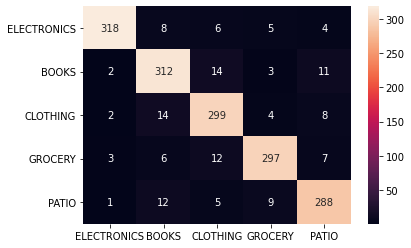

In [13]:
y_pred = clf.predict(test_x)

labels = [Category.BOOKS, Category.CLOTHING,
          Category.ELECTRONICS, Category.GROCERY, Category.PATIO]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')